Things that routine ignores 
- max non contact region
- do I need to hertz unpack func for dict ?
- unless line 51 of hertz routine is changed this there is an error.
- is there a better set of files, pre processed, or more raw fles from the nanoscope to read  

![title](hertz_model_eqn.png)

In [3]:
from pyfmreader import loadfile
from pyfmrheo.utils.force_curves import get_poc_RoV_method, get_poc_regulaFalsi_method, correct_tilt, correct_offset

from pyfmrheo.routines import doHertzFit
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os 

In [4]:
def prep_fdc_(fdc,param_dict):
    # Get segment data
    
    if param_dict['curve_seg'] == 'extend':
        segs = fdc.get_segments()

        
        segment_data = fdc.extend_segments[0][1]
        print(segment_data.zheight)
        retract_data = fdc.retract_segments[-1][1] #this is just for plotting

    else:
        segment_data = fdc.retract_segments[-1][1]
        segment_data.zheight = segment_data.zheight[::-1]
        segment_data.vdeflection = segment_data.vdeflection[::-1]
        
        
    # Perform tilt correction
    if param_dict['offset_type'] == 'percentage':
        deltaz = segment_data.zheight.max() - segment_data.zheight.min()
        maxoffset = segment_data.zheight.min() + deltaz * param_dict['max_offset']
        minoffset = segment_data.zheight.min() + deltaz * param_dict['min_offset']
        
        
        deltaz_ret = retract_data.zheight.max() - retract_data.zheight.min()
        maxoffset_ret = retract_data.zheight.min() + deltaz_ret * param_dict['max_offset']
        minoffset_ret = retract_data.zheight.min() + deltaz_ret * param_dict['min_offset']
    else:
        maxoffset = param_dict['max_offset']
        minoffset = param_dict['min_offset']
        
        maxoffset_ret = param_dict['max_offset']
        minoffset_ret = param_dict['min_offset']

    if param_dict['correct_tilt']:
        segment_data.vdeflection =\
            correct_tilt(
                segment_data.zheight, segment_data.vdeflection, maxoffset, minoffset)
            
        retract_data.vdeflection =\
            correct_tilt(
                retract_data.zheight, retract_data.vdeflection, maxoffset_ret, minoffset_ret
            )
            
    else:
        segment_data.vdeflection =\
            correct_offset(
                segment_data.zheight, segment_data.vdeflection, maxoffset, minoffset
            )
            
        retract_data.vdeflection =\
            correct_tilt(
                retract_data.zheight, retract_data.vdeflection, maxoffset_ret, minoffset_ret
            )
            
            
    # Get initial estimate of PoC
    if param_dict['poc_method'] == 'RoV':
        comp_PoC = get_poc_RoV_method(
            segment_data.zheight, segment_data.vdeflection, param_dict['poc_win'])
    else:
        comp_PoC = get_poc_regulaFalsi_method(
            segment_data.zheight, segment_data.vdeflection, param_dict['sigma'])
    
    poc = [comp_PoC[0], 0]
    poc = comp_PoC

    # Downsample signal
    if param_dict['downsample_flag']:
        downfactor= len(segment_data.zheight) // param_dict['pts_downsample']
        idxDown = list(range(0, len(segment_data.zheight), downfactor))
        segment_data.zheight = segment_data.zheight[idxDown]
        segment_data.vdeflection = segment_data.vdeflection[idxDown]
        
        
    # Prepare data for the fit
    
    #finding the POC for the whole Force curve rather than just the approach part
    
    fdc.get_force_vs_indentation(poc, param_dict['k'])
     
    #plt.show()
def raw_plt_curve(force_curve,title=None):
    curve_id_= force_curve.curve_index
    segs = force_curve.get_segments()
    ext_data = segs[0][1]
    retract_data = segs[1][1]
    temp_fig_title = f"{title}_curve_id_{curve_id_}"
    fig = plt.figure(temp_fig_title);plt.clf();
    plt.title(temp_fig_title);

    for _, segment in force_curve.get_segments():
        segment_data = segment
        plt.scatter(segment_data.zheight,segment_data.vdeflection,label = segment_data.segment_type)
        plt.xlabel("Z height ")
        plt.ylabel("deflection signal ")


    plt.legend();plt.show()
    return(fig)
    
def unpack_hertz_result(row_dict, hertz_result):
    row_dict['hertz_ind_geometry'] = hertz_result.ind_geom
    row_dict['hertz_tip_parameter'] = hertz_result.tip_parameter
    row_dict['hertz_apply_BEC'] = hertz_result.apply_bec_flag
    row_dict['hertz_BEC_model'] = hertz_result.bec_model
    row_dict['hertz_fit_hline_on_baseline'] = hertz_result.fit_hline_flag
    row_dict['hertz_delta0'] = hertz_result.delta0
    row_dict['hertz_E0'] = hertz_result.E0
    row_dict['hertz_f0'] = hertz_result.f0
    row_dict['hertz_slope'] = hertz_result.slope
    row_dict['hertz_poisson_ratio'] = hertz_result.poisson_ratio
    row_dict['hertz_sample_height'] = hertz_result.sample_height
    row_dict['hertz_MAE'] = hertz_result.MAE
    row_dict['hertz_MSE'] = hertz_result.MSE
    row_dict['hertz_RMSE'] = hertz_result.RMSE
    row_dict['hertz_Rsquared'] = hertz_result.Rsquared
    row_dict['hertz_chisq'] = hertz_result.chisq
    row_dict['hertz_redchi'] = hertz_result.redchi
    return row_dict

def process_retract_part(retract_data,approach_seg,param_dict, hertz_delta0 ):
    segment_data = retract_data
    segment_data.zheight = segment_data.zheight[::-1]
    segment_data.vdeflection = segment_data.vdeflection[::-1]
    
    # Perform tilt correction
    if param_dict['offset_type'] == 'percentage':
        deltaz = segment_data.zheight.max() - segment_data.zheight.min()
        maxoffset = segment_data.zheight.min() + deltaz * param_dict['max_offset']
        minoffset = segment_data.zheight.min() + deltaz * param_dict['min_offset']
    else:
        maxoffset = param_dict['max_offset']
        minoffset = param_dict['min_offset']
    
    if param_dict['correct_tilt']:
        segment_data.vdeflection =\
            correct_tilt(
                segment_data.zheight, segment_data.vdeflection, maxoffset, minoffset
            )
        approach_seg.vdeflection =\
            correct_tilt(
                approach_seg.zheight, approach_seg.vdeflection, maxoffset, minoffset
            )
    else:
        segment_data.vdeflection =\
            correct_offset(
                segment_data.zheight, segment_data.vdeflection, maxoffset, minoffset
            )
    # Get initial estimate of PoC
    if param_dict['poc_method'] == 'RoV':
        comp_PoC = get_poc_RoV_method(
            approach_seg.zheight, approach_seg.vdeflection, param_dict['poc_win'])
    else:
        comp_PoC = get_poc_regulaFalsi_method(
            approach_seg.zheight, approach_seg.vdeflection, param_dict['sigma'])
    #print("poc parameters",comp_PoC)
    poc = [comp_PoC[0], 0]
    poc[0]+=hertz_delta0
    
    segment_data.get_force_vs_indentation(poc, param_dict['k'])


In [5]:
# Define path of file to process
folder_path = '/Users/yogehs/Documents/ATIP_PhD/tutorial_pyfmrheo_gren/test_files/'
file_paths_in_folder = sorted([folder_path+f for f in os.listdir(folder_path) if Path(f).suffix[1:].isnumeric()])
file_paths_in_folder
file_path = file_paths_in_folder[0]
file_paths_in_folder

['/Users/yogehs/Documents/ATIP_PhD/tutorial_pyfmrheo_gren/test_files/cr00000.000',
 '/Users/yogehs/Documents/ATIP_PhD/tutorial_pyfmrheo_gren/test_files/cr00001.000',
 '/Users/yogehs/Documents/ATIP_PhD/tutorial_pyfmrheo_gren/test_files/cr00002.000',
 '/Users/yogehs/Documents/ATIP_PhD/tutorial_pyfmrheo_gren/test_files/cr00003.000',
 '/Users/yogehs/Documents/ATIP_PhD/tutorial_pyfmrheo_gren/test_files/cr00004.000',
 '/Users/yogehs/Documents/ATIP_PhD/tutorial_pyfmrheo_gren/test_files/cr00005.000']

In [6]:
# Load File
file = loadfile(file_path)
filemetadata = file.filemetadata

print(filemetadata['file_type'])


000


In [7]:
# Define parameters to perform the HertzFit

# Get some of the file metadata
closed_loop = filemetadata['z_closed_loop']
file_deflection_sensitivity = filemetadata['defl_sens_nmbyV'] #nm/V
file_spring_constant = filemetadata['spring_const_Nbym'] #N/m
height_channel = filemetadata['height_channel_key']

deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
spring_constant = file_spring_constant

print(f"Closed loop: {closed_loop}")
print(f"Height channel: {height_channel}")
print(f"Deflection Sens.: {deflection_sensitivity} m/V")
print(f"Spring Constant: {spring_constant} N/m")
maxnoncontact = 1e-6 #um

param_dict = {
    'height_channel': height_channel,   # Channel where to find the height data
    'def_sens': deflection_sensitivity, # Deflection sensitivity in m/V
    'k': spring_constant,               # Spring constant in N/m
    'contact_model': 'pyramid',      # Geometry of the indenter: paraboloidal, conical, pyramidal
    'tip_param': 35,                 # Tip raidus in meters or tip angle in degrees
    'curve_seg': 'extend',              # Segement to perform the fit: extend or retract
    'correct_tilt': True,              # Perform tilt correction
    'tilt_min_offset': 1e-08,           # Maximum range where to perform the tilt correction in meters
    'tilt_max_offset': 1e-06,           # Minimum range where to perform the tilt correction in meters
    'poisson': 0.5,                     # Poisson's ratio
    'poc_method': 'RoV',                # Method to find the contact point: RoV or RegulaFalsi
    'poc_win': 3e-07,                   # Window size for the RoV method
    'min_ind': 0.0,                     # Maximum indentation range for fit in meters
    'max_ind': 1000e-09,                     # Minimum indentation range for fit in meters
    'max_force': 0.0,                   # Maximum force range for fit in Newtons
    'min_force': 0.0,                   # Minimum force range for fit in Newtons
    'fit_range_type': 'indentation',           # Fit data range: full, indentation or force
    'd0': 0.0,                          # Initial point of contact
    'slope': 0.0,                       # Initial slope
    'auto_init_E0': True,               # Estimate automatically the initial value of the Young's Modulus
    'E0': 500,                         # Initial Young's Modulus value
    'f0': 0.0,                          # Initial F0 value
    'contact_offset': maxnoncontact,    # Baseline offset for the Hertz Fit
    'fit_line': False,                  # Fit line to the baseline
    'downsample_flag': False,            # Downsample the signal for Hertz Fit
    'pts_downsample': 0,   # Number of points to downsample
    'offset_type':'percentage',         # How to correct for baseline offset: percentage or value
    'max_offset':.3,                    # Max percentage to compute offset
    'min_offset':0.1                      # Min percentage to compute offset
}

Closed loop: Off
Height channel: height
Deflection Sens.: 3.036768e-08 m/V
Spring Constant: 0.042804 N/m


000


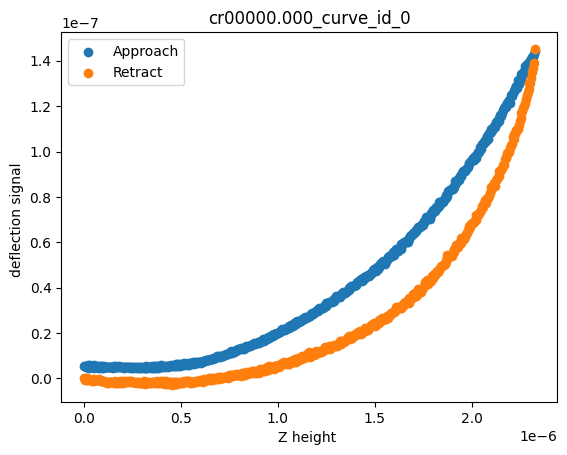

000


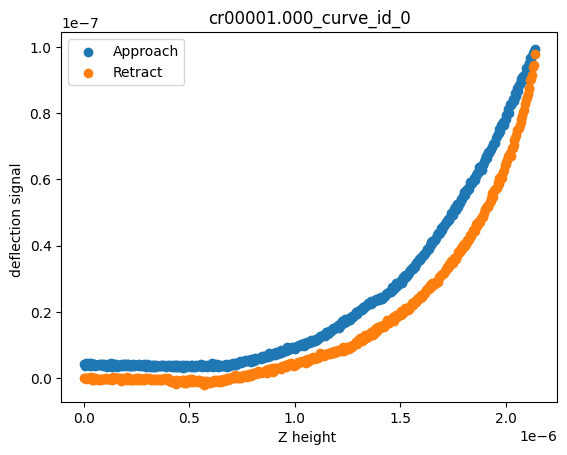

000


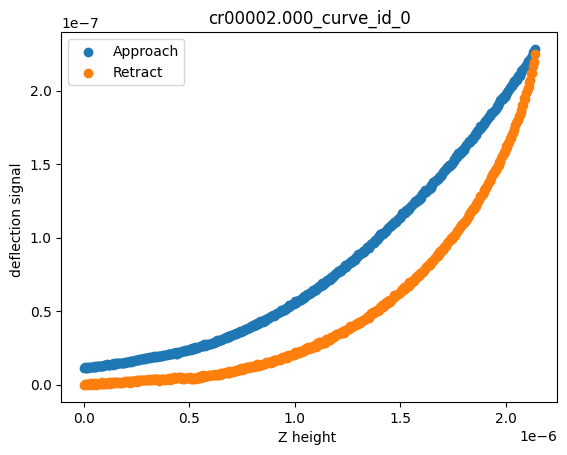

000


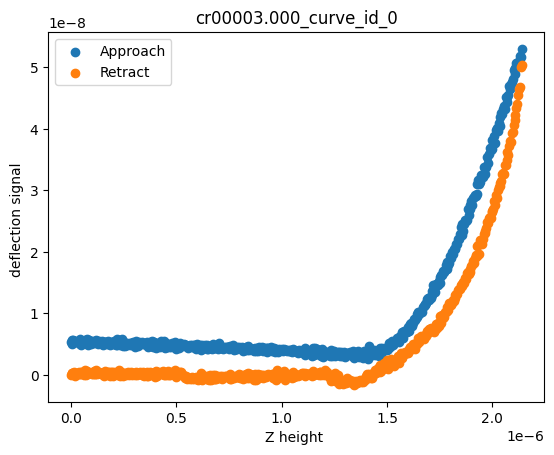

000


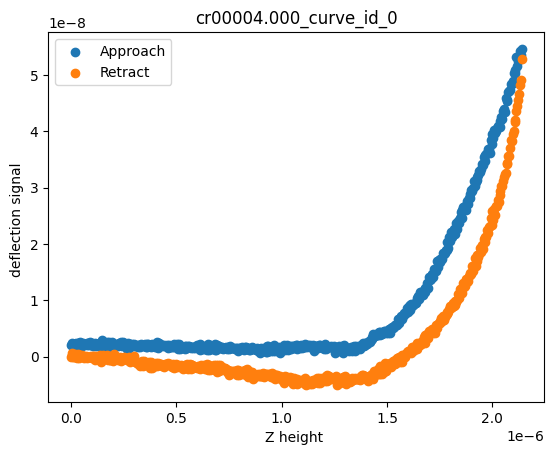

000


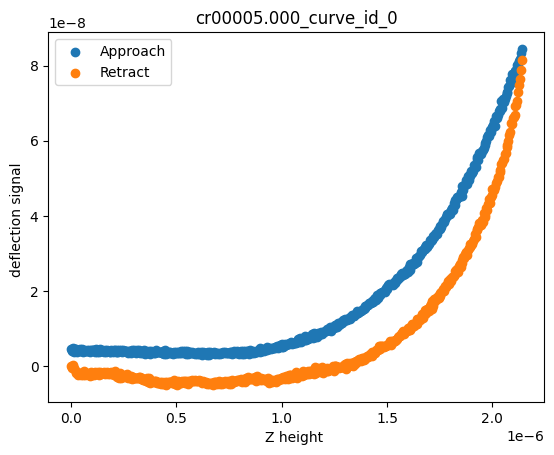

In [9]:
#to visualise the raw curves that stored the folder

for file_path in file_paths_in_folder:
    file = loadfile(file_path)
    filemetadata = file.filemetadata
    
    print(filemetadata['file_type'])

    force_curve = file.getcurve(0)
    force_curve.preprocess_force_curve(param_dict['def_sens'], param_dict['height_channel'])

    raw_plt_curve(force_curve,filemetadata['Entry_filename'])
    

In [10]:
# Select curve by index
force_curve = file.getcurve(0)
# Preprocess curve
force_curve.preprocess_force_curve(param_dict['def_sens'], param_dict['height_channel'])
# JPK files require the height signal to be shifted
if filemetadata['file_type'] in ('jpk-force', 'jpk-force-map', 'jpk-qi-data'):
    force_curve.shift_height()

In [11]:
# Run fit
hertz_result = doHertzFit(force_curve, param_dict)


/Users/yogehs/src/pyfmrheo-dynamo/src/pyfmrheo/models/hertz.py:169: RuntimeWarning: divide by zero encountered in divide
  a = (self.get_residuals(indentation, force, sample_height)**2/force)


In [12]:

# Check Hertz Result values
hertz_result.fit_report()


        # Fit parameters
        Indenter shape: pyramid

        Tip paraneter: 35

        Correction Model: None

        Number of free parameters: 3

        delta0: 6.017505878598023e-08

        E0: 2638.8836254823786

        f0: -7.375071038511301e-11

        slope: None

        # Fit metrics
        MAE: 6.660613388641833e-22

        MSE: 1.5337791592262984e-20

        RMSE: 1.238458380094502e-10

        Rsq: 0.9823979177109378

        Chisq: 1.1511233004458912e-07

        RedChisq: 3.8370776681529705e-08

        


[0.00000000e+00 4.18510782e-09 8.37021564e-09 1.25553235e-08
 1.67404313e-08 2.09255391e-08 2.51106469e-08 2.92957547e-08
 3.34808625e-08 3.76659704e-08 4.18510782e-08 4.60361860e-08
 5.02212938e-08 5.44064016e-08 5.85915095e-08 6.27766173e-08
 6.69617251e-08 7.11468329e-08 7.53319407e-08 7.95170485e-08
 8.37021564e-08 8.78872642e-08 9.20723720e-08 9.62574798e-08
 1.00442588e-07 1.04627695e-07 1.08812803e-07 1.12997911e-07
 1.17183019e-07 1.21368127e-07 1.25553235e-07 1.29738342e-07
 1.33923450e-07 1.38108558e-07 1.42293666e-07 1.46478774e-07
 1.50663881e-07 1.54848989e-07 1.59034097e-07 1.63219205e-07
 1.67404313e-07 1.71589421e-07 1.75774528e-07 1.79959636e-07
 1.84144744e-07 1.88329852e-07 1.92514960e-07 1.96700067e-07
 2.00885175e-07 2.05070283e-07 2.09255391e-07 2.13440499e-07
 2.17625607e-07 2.21810714e-07 2.25995822e-07 2.30180930e-07
 2.34366038e-07 2.38551146e-07 2.42736253e-07 2.46921361e-07
 2.51106469e-07 2.55291577e-07 2.59476685e-07 2.63661793e-07
 2.67846900e-07 2.720320

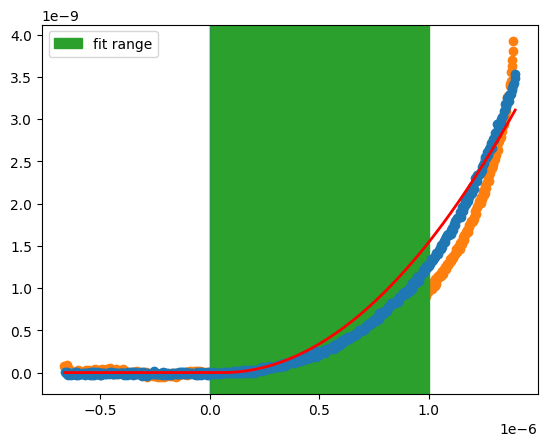

In [13]:

prep_fdc_(force_curve,param_dict)
segs = force_curve.get_segments()
ext_data = segs[0][1]
ret_data = segs[1][1]

fig = plt.figure(file_path)

plt.scatter(ext_data.indentation, ext_data.force,zorder =2 )
plt.scatter(ret_data.indentation, ret_data.force,zorder = 1)

plt.plot(ext_data.indentation, hertz_result.eval(
    ext_data.indentation)-hertz_result.f0, zorder=3, color='red',linewidth = 2)
plt.axvspan(param_dict['min_ind'],param_dict['max_ind'],color = 'tab:green',label ="fit range")
plt.axvline(0,alpha =0.2)
plt.legend()

plt.show()

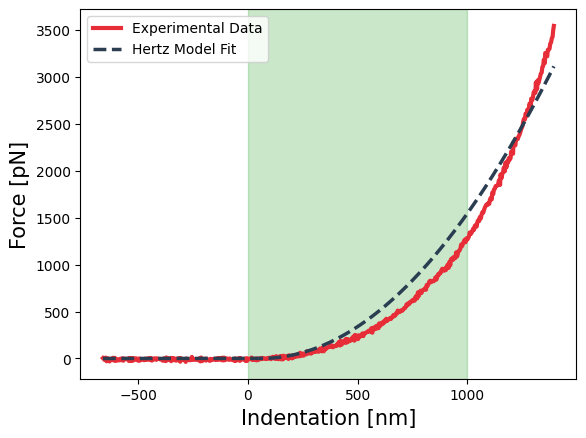

In [14]:
# Plot Hertz Fit
plt.plot(
    ext_data.indentation * 1e9,
    ext_data.force * 1e12,
    color='#E72E38',
    linewidth=3,
    label='Experimental Data'
)

plt.plot(ext_data.indentation * 1e9,
    (hertz_result.eval(ext_data.indentation)-hertz_result.f0 ) * 1e12,
    color='#2B3E51',
    linewidth=2.5,
    linestyle='--',
    label='Hertz Model Fit')
plt.axvspan(param_dict['min_ind']* 1e9,param_dict['max_ind']* 1e9,color = 'tab:green',alpha = 0.25)

plt.xlabel('Indentation [nm]', fontsize = 15)
plt.ylabel('Force [pN]', fontsize = 15)
plt.legend()
plt.show()

/home/felix/anaconda3/envs/PyFMLab/lib/python3.9/site-packages/pyfmrheo/models/hertz.py:161: RuntimeWarning: divide by zero encountered in divide
  a = (self.get_residuals(indentation, force, sample_height)**2/force)


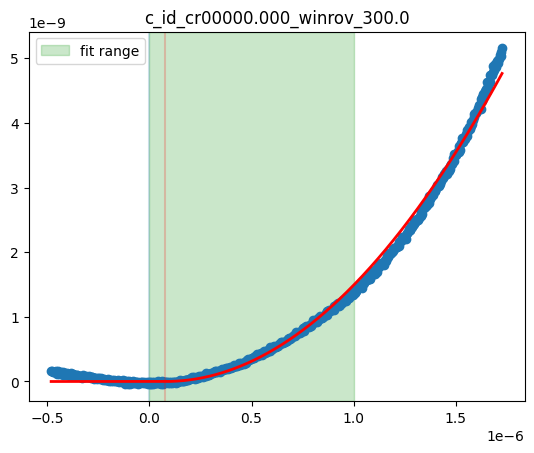

/home/felix/anaconda3/envs/PyFMLab/lib/python3.9/site-packages/pyfmrheo/models/hertz.py:161: RuntimeWarning: divide by zero encountered in divide
  a = (self.get_residuals(indentation, force, sample_height)**2/force)


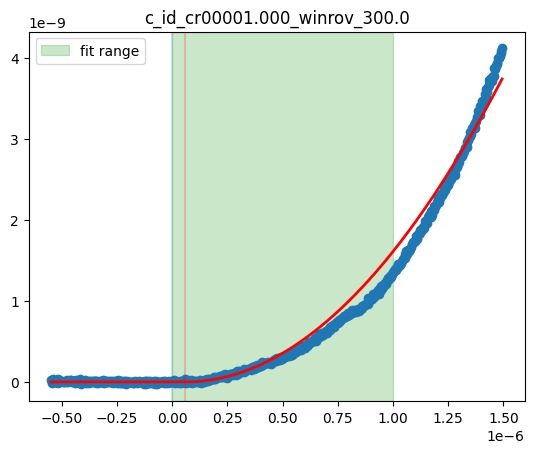

/home/felix/anaconda3/envs/PyFMLab/lib/python3.9/site-packages/pyfmrheo/models/hertz.py:161: RuntimeWarning: divide by zero encountered in divide
  a = (self.get_residuals(indentation, force, sample_height)**2/force)


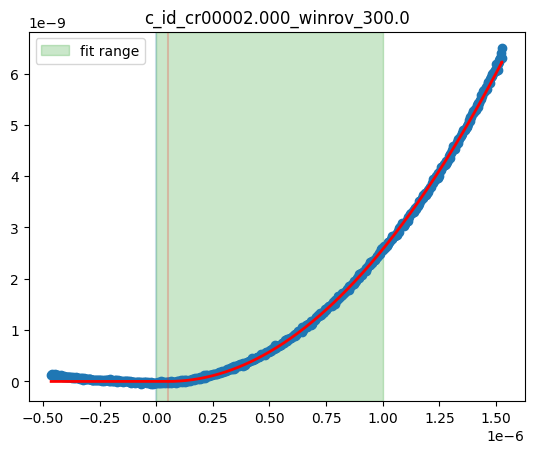

/home/felix/anaconda3/envs/PyFMLab/lib/python3.9/site-packages/pyfmrheo/models/hertz.py:161: RuntimeWarning: divide by zero encountered in divide
  a = (self.get_residuals(indentation, force, sample_height)**2/force)


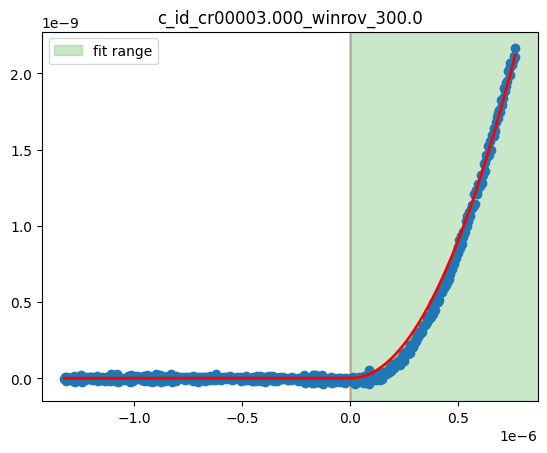

/home/felix/anaconda3/envs/PyFMLab/lib/python3.9/site-packages/pyfmrheo/models/hertz.py:161: RuntimeWarning: divide by zero encountered in divide
  a = (self.get_residuals(indentation, force, sample_height)**2/force)


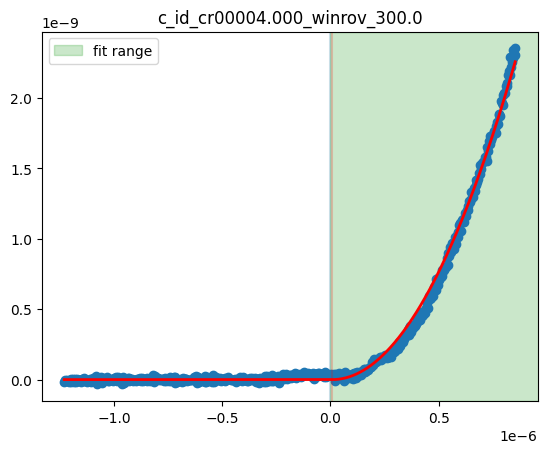

/home/felix/anaconda3/envs/PyFMLab/lib/python3.9/site-packages/pyfmrheo/models/hertz.py:161: RuntimeWarning: divide by zero encountered in divide
  a = (self.get_residuals(indentation, force, sample_height)**2/force)


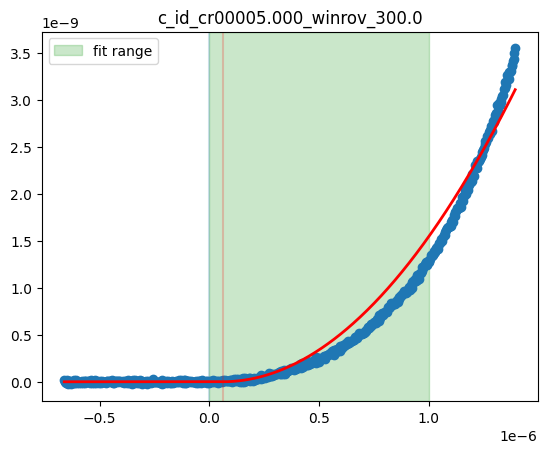

In [67]:
#loop cell to loop the analysis over all curves in the map  

for file_path in file_paths_in_folder:
    file = loadfile(file_path)
    filemetadata = file.filemetadata

    
    fig_title = f"c_id_{filemetadata['Entry_filename']}_winrov_{param_dict['poc_win']*1e9}"

    raw_row_op = {'file_path': file_path, 
                   'kcanti': spring_constant, 'defl_sens': deflection_sensitivity,
                  'error_raised': None}
    #getting the curve 
    force_curve = file.getcurve(0)

    # Preprocess curve
    force_curve.preprocess_force_curve(
        param_dict['def_sens'], param_dict['height_channel'])
    # JPK files require the height signal to be shifted
    if filemetadata['file_type'] in ('jpk-force', 'jpk-force-map', 'jpk-qi-data'):
        force_curve.shift_height()
    #error hanidnlt to continue/ignore curves with error
    try:

        hertz_result = doHertzFit(force_curve, param_dict)
        # hertz_result.fit_report()
        segs = force_curve.get_segments()
        ext_data = segs[0][1]
        ret_data = segs[1][1]
        indentation_full = ext_data.indentation

        fig = plt.figure(file_path)
        
        plt.title(fig_title)
        plt.scatter(ext_data.indentation, ext_data.force,zorder =2 )
        plt.scatter(ret_data.indentation, ret_data.force,alpha = 0.01,zorder = 1)

        plt.plot(indentation_full, hertz_result.eval(
            indentation_full)-hertz_result.f0, zorder=3, color='red',linewidth = 2)
        plt.axvspan(param_dict['min_ind'],param_dict['max_ind'],color = 'tab:green',alpha = 0.25,label ="fit range")
        plt.axvline(0,alpha =0.2)
        plt.axvline(hertz_result.delta0, color='red',alpha = 0.2)
        plt.legend()

        plt.show()
        


    except TypeError:
        raw_row_op['error_raised'] = "TypeError"
        raw_row_op['good_bool'] = False

        fig = raw_plt_curve(force_curve, raw_row_op['error_raised'])
        print(f"Type error: {file_path} ")
        
    except ValueError:

        raw_row_op['error_raised'] = "ValueError"
        raw_row_op['good_bool'] = False

        fig = raw_plt_curve(force_curve, raw_row_op['error_raised'])
        
        print(f"ValueError : {file_path} ")


        
